# Beautif.ai classification

The goal of your project is to create a robust classifier, to collect data and prepare custom dataset.  
You will build a model that will recognize 4 types of natural events in nature/indoor/outdoor:

* Daylight sky 
  * <img src = "https://ak.picdn.net/shutterstock/videos/7077064/thumb/1.jpg" width = "50%" height="50%">
* Sky at night
  * <img src="https://i.pinimg.com/originals/ec/98/dd/ec98dd97904e60661b1d545a88006e6a.jpg" width="50%" height="50%"/>

* Picture doesn't contain sky (no matter it's day or night)
  * <img src= "https://www.hotelsolun.com/application/files/5515/6285/1004/1X9A8812.jpg" width="50%" height="50%"/>


This project consists of the following activities :


1. Phase 1 : Dataset
    * Team Planning
    * Full git project Integration
    * General Project Research
    * Dataset Collection
    * Dataset Preparation
2. Phase 2 : Training
    * Research about neural networks
    * Compose neural network architectures
    * Ping Pong phase with Dataset labelers
    * Generate syntethic data if needed
    * Fine tunning of your model
3. Phase 3 : Deployment
    * Analysis and benchmark Precision/Recall
    * Model Deploy (Git)
    * Write git Readme.md file
    * Receive Feedback from PM


# Load Data

In [1]:
import os, sys, shutil, random, cv2
from google.colab import drive
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.datasets import load_files
from sklearn.metrics import classification_report

import keras
from tensorflow.keras.utils import to_categorical
from keras.utils import np_utils
from keras.applications.xception import preprocess_input as X_pre
from keras.applications.resnet50 import preprocess_input as Res_pre

from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing import image

from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications.xception import Xception
from keras.applications.densenet import DenseNet169
from keras.applications.resnet import ResNet50

from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Activation, Conv2D, Flatten, MaxPooling2D, AveragePooling2D, Dropout, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint

plt.style.use( "ggplot" )

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def split_test_valid( split_ratio, set_path, random_seed = 1, print_ratio = False, include_path = True ) :

    """
    This functions lists through a directory containing different sets in sorted subdirectories and returns test_x, valid_x, test_labels, valid_labels ( or x and y ) for further use.
    The arguments that need to be provided:
        split_ratio: is the ratio for the data set to be split along. Acceptable input is a float between 0 and 1 i.e. the percentage needed for further use; 
        set_path: is the path to the main directory where the subdirectories are located.
    Optional arguments:
         random_seed: is self-explanatory;
         print_ratio: prints the int ratio of the split.
         include_path: whether or not to include the full path in the train and test sets.
            If True returns: '/content/drive/MyDrive/Directory/Subdirectiory/Image.jpg';
            If False returns: 'Image.jpg'.
    """

    random.seed( random_seed )
    
    total = 0

    test_x = []
    valid_x = []
    test_labels = []
    valid_labels = []

    default_location = os.getcwd()

    if set_path[ -1 ] == "/" :
        set_path = set_path[0:-1]

    os.chdir( set_path )
    list_dir = os.listdir( set_path )

    for folder in list_dir :
        os.chdir( f'{ set_path}/{ folder }' )
        how_many =  len( os.listdir() )
        total += how_many

        test_set = int( round( how_many * ( 1 - split_ratio ), 0 ) )
        valid_set = int( round( how_many * split_ratio, 0 ) )

        nums = [ x for x in range( 1, how_many ) ]
        random_nums = random.sample( nums, valid_set )

        # The split itself :
        for ind, item in enumerate( os.listdir() ):

            if ind in random_nums :
                if include_path == True :
                    valid_x.append( f"{set_path}/{folder}/{item}" )
                elif include_path == False :
                    valid_x.append( item )

                valid_labels.append( folder )

            if ind not in random_nums :

                if include_path == True :
                    test_x.append( f"{set_path}/{folder}/{item}" )
                elif include_path == False :
                    test_x.append( item )

                test_labels.append( folder )

        if print_ratio == True :

            print( f"Set: { folder } - { how_many } items" )
            print( f"Train: { test_set }" )
            print( f"Validation: { valid_set }" )
            print( f"Total: { test_set + valid_set }" )
            print( "---------" )
        elif print_ratio == False :
            pass

    os.chdir( default_location )
    
    if print_ratio == True :
        test_set = int( round( total * ( 1 - split_ratio ), 0 ) )
        valid_set = int( round( total * split_ratio, 0 ) )

        print( "---------" ) 
        print( f"United set: { total } items" )
        print( f"Train: { test_set }" )
        print( f"Validation: { valid_set }" )
        print( f"Total: { test_set + valid_set }" )
        print( "---------" )
    elif print_ratio == False :
            pass

    return test_x, valid_x, test_labels, valid_labels

In [8]:
set_path = "/content/drive/MyDrive/labeled_resized_224x224"
split_ratio = 0.15

train_x, validation_x, train_labels, validation_labels  = split_test_valid( split_ratio, set_path, random_seed = 42, print_ratio = True )

Set: No_Sky - 3826 items
Train: 3252
Validation: 574
Total: 3826
---------
Set: Night-Not_Separated - 884 items
Train: 751
Validation: 133
Total: 884
---------
Set: Day - 3273 items
Train: 2782
Validation: 491
Total: 3273
---------
Set: Night-Separated - 657 items
Train: 558
Validation: 99
Total: 657
---------
---------
United set: 8640 items
Train: 7344
Validation: 1296
Total: 8640
---------


In [9]:
train_labels = np.array(train_labels)
validation_labels = np.array(validation_labels)

le = preprocessing.LabelEncoder()

le.fit(train_labels)

train_targets = le.transform(train_labels)
val_targets = le.transform(validation_labels)

train_targets = np_utils.to_categorical(train_targets,num_classes=4)
val_targets = np_utils.to_categorical(val_targets,num_classes=4)

# Visualize Data Distribution

# Image Preprocessing

In [ ]:
def load_image( path ) :
  # READ AND PREPROCESS IMAGE HERE
  #cv2.imread
  image = cv2.imread( path ).astype( np.float32 )
  image_resized = X_pre( image )
  return image_resized

def load_dataset( files ) :

  print( "Preprocess initalized...\n" )

  process = 0
  len_dir = len( files )
  vector = []
  brojcanik = 0
  for file in files :

    vector.append( load_image( file ) )

    process += 1
    process_percentage = round( ( process / len_dir ) * 100, 0 )
    process_output = f"Processed: { process } / { len_dir } - { int( process_percentage ) }%"
    sys.stdout.write( '\r' + process_output )
    
  print( f"\n\n{ files } preprocess completed." )
  
  return np.array( vector )


X_train = load_dataset( train_x )
X_val = load_dataset( validation_x )

Preprocess initalized...

Processed: 4545 / 7343 - 62%

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

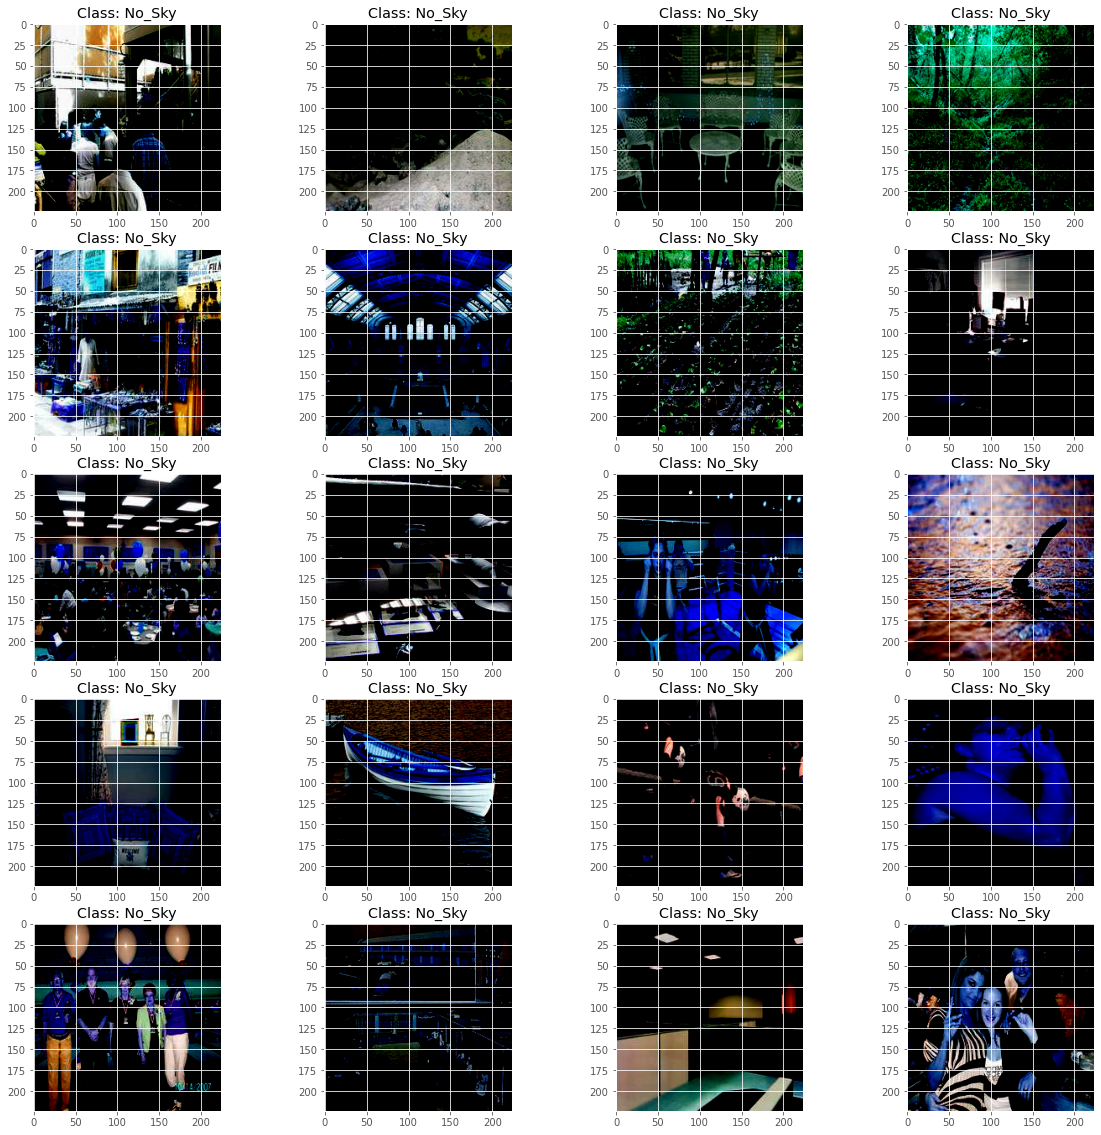

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,20))

for i in range( 5 * 4 ) :
    # dodavanje na podgrafik
    ax1 = fig.add_subplot( 5, 4, ( i + 1 ) )
    # crtanje na podgrafikot
    ax1.imshow( X_train[ i ] )
    #  dodavanje na tekst na podgrafikot
    title = "Class: " + train_labels[ i ]
    plt.title( title )

# snimanje na grafikot
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

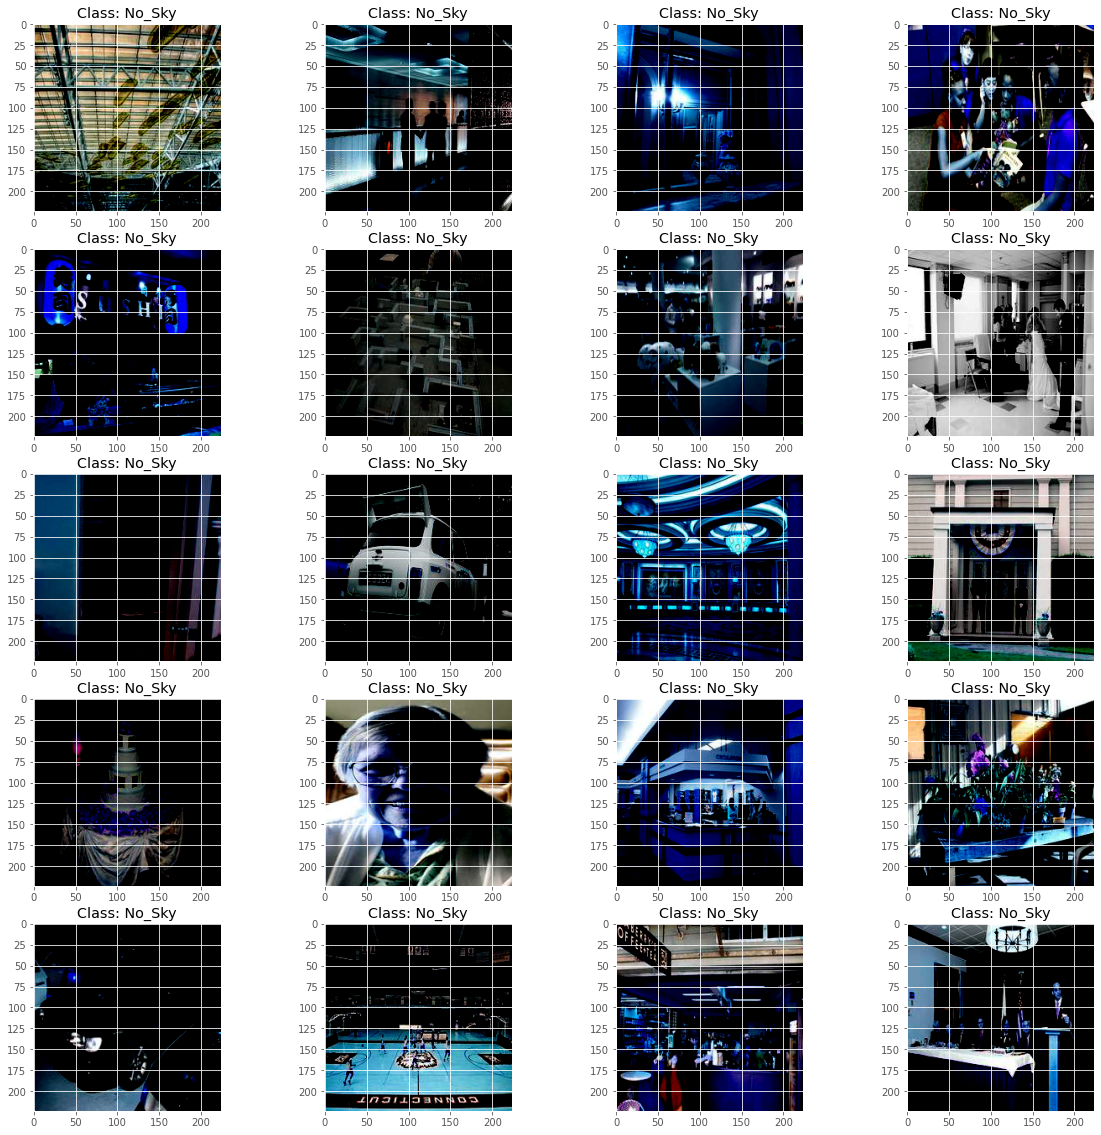

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,20))

for i in range( 5 * 4 ) :
    # dodavanje na podgrafik
    ax1 = fig.add_subplot( 5, 4, ( i + 1 ) )
    # crtanje na podgrafikot
    ax1.imshow( X_val[ i ] )
    #  dodavanje na tekst na podgrafikot
    title = "Class: " + validation_labels[ i ]
    plt.title( title )

# snimanje na grafikot
plt.show()

# Define Model Architecture

In [ ]:
model = Xception( include_top = False, input_shape = ( 224, 224, 3 ), weights = 'imagenet' )
for layer in model.layers[ : -20 ] :
  layer.trainable = False
flat = Flatten()( model.output )
hidden = Dense( 1024, activation = 'relu' )( flat )
outputs = Dense( 4, activation = 'softmax' )( hidden )
model = Model( inputs = model.inputs, outputs = outputs )

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

# Define Loss Function, Optimizator

In [ ]:
optimzer = keras.optimizers.Adam( lr = 0.00001 )
model.compile( loss = 'categorical_crossentropy', optimizer = optimzer, metrics = [ 'accuracy' ] )

# Define Augmentator 

In [ ]:
checkpoint = ModelCheckpoint(     
                                'Xception_model3_Dimitri.pt', monitor = 'val_accuracy',
                                verbose = 1, save_best_only = True, mode = 'max'
                               )
model.fit(
                    X_train,
                    train_targets,
                    validation_data = ( X_val, val_targets ),
                    epochs = 100,
                    callbacks = [ checkpoint ], 
                    batch_size = 50
                        )

Epoch 1/100
147/147 [==============================] - 55s 307ms/step - loss: 0.8122 - accuracy: 0.7024 - val_loss: 0.5236 - val_accuracy: 0.8272

Epoch 00001: val_accuracy improved from -inf to 0.82716, saving model to /content/drive/MyDrive/Models/Dimitri/Model 2/Xception_model2_Dimitri.pt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/Dimitri/Model 2/Xception_model2_Dimitri.pt/assets
Epoch 2/100
147/147 [==============================] - 44s 297ms/step - loss: 0.2591 - accuracy: 0.9188 - val_loss: 0.4898 - val_accuracy: 0.8441

Epoch 00002: val_accuracy improved from 0.82716 to 0.84414, saving model to /content/drive/MyDrive/Models/Dimitri/Model 2/Xception_model2_Dimitri.pt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/Dimitri/Model 2/Xception_model2_Dimitri.pt/assets
Epoch 3/100
147/147 [==============================] - 45s 304ms/step - loss: 0.1230 - accuracy: 0.9712 - val_loss: 0.4105 - val_accuracy: 0.8634

Epoch 00003: val_accuracy improved

In [ ]:


Y_pred = model.predict( X_val )

target_names = [ 'Day', 'Night-Not_Separated', 'Night-Separated', 'No_Sky' ]

print( classification_report( val_targets, Y_pred.round(), target_names = target_names ) )

                     precision    recall  f1-score   support

                Day       0.90      0.91      0.90       496
Night-Not_Separated       0.77      0.76      0.76       132
    Night-Separated       0.79      0.60      0.68        94
             No_Sky       0.90      0.92      0.91       574

          micro avg       0.88      0.88      0.88      1296
          macro avg       0.84      0.80      0.81      1296
       weighted avg       0.88      0.88      0.88      1296
        samples avg       0.88      0.88      0.88      1296



# Example :  
   Provide several examples of predictions along with softmax score probability

# Benchmark

# Summary about your results